# 転移学習の実装

## 実装の初期設定

In [83]:
#パッケージのインポート
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

In [84]:
#乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Datasetを作成

In [85]:
#入力画像の前処理をするクラス
#訓練時と推論時で処理が異なる
class ImageTransform():
    """
    画像の前処理クラス。訓練時・検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizeCropとRandomHorizontalFlipでデータオーギュメンテーションする

    Attributes
    ____________
    resize : int
        リサイズ先の画像の大きさ
    mean : (R,G,B)
        各色チャネルの平均値
    std : (R,G,B)
        各色チャネルの標準偏差

    """

    def __init__(self,resize,mean,std):
        self.data_transform={
            "train":transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5,1.0)), #データオーギュメンテーション
                transforms.RandomHorizontalFlip(), #データオーギュメンテーション
                transforms.ToTensor(), #テンソルに変換
                transforms.Normalize(mean,std) #標準化
            ]),
            "val":transforms.Compose([
                transforms.Resize(resize), #リサイズ
                transforms.CenterCrop(resize), #画像中央をresize*resizeで切り取る
                transforms.ToTensor(), #テンソルに変換
                transforms.Normalize(mean,std) #標準化
            ])
        }
    
    def __call__(self,img,phase="train"):
        """
        Parameters
        -------------
        phase: "train" or "val"
            前処理モードの指定。
        """
        
        return self.data_transform[phase](img)
    

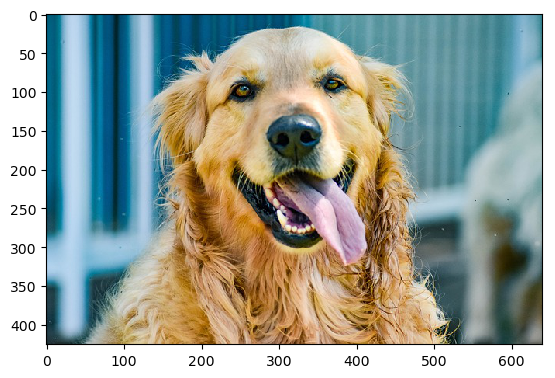

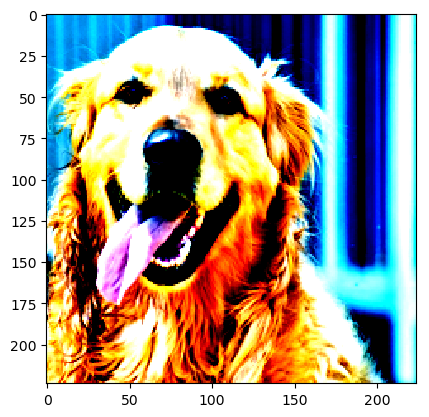

In [6]:
#訓練時の画像前処理の動作を確認
#実行するたびに処理結果の画像が変わる

#1. 画像読み込み
image_file_path="../1_image_classification/data/goldenretriever-3724972_640.jpg"
img=Image.open(image_file_path)

#2. 元の画像の表示
plt.imshow(img)
plt.show()

#3. 画像の前処理と処理済み画像の表示
size=224
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)

transform=ImageTransform(size,mean,std)
img_transformed=transform(img, phase="train")

#(色、高さ、幅)を(高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed=img_transformed.numpy().transpose((1,2,0))
img_transformed=np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()



### データへのファイルパスを格納したリスト型変数を作成

In [86]:
#アリとハチの画像へのファイルパスのリストを作成する
from sklearn.model_selection import train_test_split


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ---------------
    phase : "train" or "val"
       訓練データか検証データかを指定する


    Returns
    ---------------
    path_list : list
       データへのパスを格納したリスト
    """

    rootpath="../1_image_classification/data/hymenoptera_data/"
    target_path=osp.join(rootpath+phase+"/**/*.jpg")
    print(target_path)

    path_list=[] #ここに格納する

    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

#実行
train_list=make_datapath_list(phase="train")
val_list=make_datapath_list(phase="val")

train_list

../1_image_classification/data/hymenoptera_data/train/**/*.jpg
../1_image_classification/data/hymenoptera_data/val/**/*.jpg


['../1_image_classification/data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg',
 '../1_image_classification/data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg',
 '../1_image_classificat

In [87]:
val_list[3]

'../1_image_classification/data/hymenoptera_data/val/bees/2103637821_8d26ee6b90.jpg'

In [88]:
val_list[3][52:56]

'bees'

### Datasetのクラスを作成し、訓練データと検証データについてそれぞれのインスタンスを作成

In [89]:
#アリとハチの画像のDatasetを作成する
class HymenopteraDataset(data.Dataset):
    """ 
    アリとハチの画像のDatasetを作成する

    Attributes
    ---------------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : "train" or "test" 
        訓練か検証かを設定する
    """

    def __init__(self,file_list,transform=None,phase="train"):
        self.file_list=file_list #ファイルパスのリスト
        self.transform=transform #前処理クラスのインスタンス
        self.phase=phase #tran or val の設定

    def __len__(self):
        """画像の枚数を返す"""
        return len(self.file_list)

    def __getitem__(self,index):
        """ 
        前処理をした画像のTensor形式のデータとラベルを取得
        """

        #index番目の画像をロード
        img_path=self.file_list[index]
        img=Image.open(img_path) #[高さ][幅][色RGB]

        #画像の前処理を実施
        img_transformed=self.transform(
            img,self.phase) #torch.Size([3,224,224])

        #画像のラベルをファイル名から抜き出す
        if self.phase=="train":
            label=img_path[54:58]
        elif self.phase=="val":
            label=img_path[52:56]

        #ラベルを数値に変更する
        if label=="ants":
            label=0
        elif label=="bees":
            label=1

        return img_transformed,label

In [90]:
#実行
train_dataset=HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size,mean,std),phase="train")

val_dataset=HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size,mean,std), phase="val")

#動作確認
index=0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


## DataLoaderを作成

In [92]:
#ミニバッチのサイズを指定
batch_size=32

#DataLoaderを作成
train_dataloader=torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size, shuffle=True)

val_dataloader=torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

#辞書型変数にまとめる
dataloaders_dict={"train":train_dataloader, "val":val_dataloader}

In [93]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9ad9a904a8>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f9ad9a904e0>}

In [29]:
#動作確認
batch_iterator=iter(dataloaders_dict["train"])
inputs, labels=next(batch_iterator)
print(inputs.size)
print(labels)

<built-in method size of Tensor object at 0x7f9ae9d5bfc0>
tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0])


以上でデータを使用するための準備が完了。

## ネットワークモデルの作成

In [94]:
#学習済みのVGG-16モデルをロード
#VGG-16モデルのインスタンスを生成
use_pretrained=True #学習済みのパラメータを使用
net=models.vgg16(pretrained=use_pretrained)
#net.eval() #推論モードに設定

In [34]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [95]:
net.classifier
#最後の方の層ってことね

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [96]:
#VGG-16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6]=nn.Linear(in_features=4096,out_features=2)

In [37]:
#訓練モードに設定
net.train()

print("ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました。")

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました。


## 損失関数を定義

In [38]:
#損失関数の設定
criterion=nn.CrossEntropyLoss()

## 最適化手法を設定

In [97]:
#転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update=[]

#学習させるパラメータ名
update_param_names=["classifier.6.weight", "classifier.6.bias"]

In [100]:
#学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name,param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad=True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad=False

#params_to_updateの中身を確認
print("--------------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
--------------
[Parameter containing:
tensor([[-0.0109,  0.0036, -0.0132,  ...,  0.0019,  0.0018, -0.0121],
        [-0.0107,  0.0017,  0.0034,  ...,  0.0134,  0.0052, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([-0.0060,  0.0011], requires_grad=True)]


In [98]:
net.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [101]:
#最適化手法の設定
optimizer=optim.SGD(params=params_to_update, lr=0.01, momentum=0.9)

## 学習・検証を実施

In [102]:
#モデルを学習させる関数を作成
def train_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
    #epochのループ
    for epoch in range(num_epochs):
        print("Epoch {}/{}" .format(epoch+1, num_epochs))
        print("--------------------")

        #epochごとの学習と検証のループ
        for phase in ["train","val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            
            epoch_loss=0.0 #epochの損失和
            epoch_corrects=0 #epochの正解数

            #未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch==0) and (phase=="train"):
                continue

            #データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                #optimizerの初期化
                optimizer.zero_grad()

                #順伝播(forward)計算
                with torch.set_grad_enabled(phase=="train"):
                    outputs=net(inputs)
                    loss=criterion(outputs,labels) #損失を計算
                    _,preds=torch.max(outputs,1) #ラベルを予測

                    #訓練時はバックプロパゲーション
                    if phase=="train":
                        loss.backward()
                        optimizer.step()

                    #イテレーション結果の計算
                    #lossの合計を更新
                    epoch_loss+=loss.item()*inputs.size(0)
                    #正解数の合計を更新
                    epoch_corrects+=torch.sum(preds==labels.data)

            #epochごとのlossと正解率を表示
            epoch_loss=epoch_loss/len(dataloaders_dict[phase].dataset)
            epoch_acc=epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

In [103]:
#学習・検証を実行する
num_epoch=2
train_model(net,dataloaders_dict,criterion,optimizer,num_epochs=num_epoch)

Epoch 1/2
--------------------


100%|██████████| 5/5 [01:14<00:00, 14.87s/it]


val Loss: 0.7704 Acc: 0.4444
Epoch 2/2
--------------------


100%|██████████| 8/8 [02:03<00:00, 15.44s/it]


train Loss: 0.5211 Acc: 0.7984


100%|██████████| 5/5 [04:00<00:00, 48.04s/it] 

val Loss: 0.1858 Acc: 0.9477


以下落書き

In [59]:
dataloaders_dict["train"].dataset

In [57]:
labels

tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0])

In [54]:
net.train()==net.eval


False

In [ ]:
net.train()